In [1]:
%load_ext autoreload
%autoreload 2

# Simulacion de distribuciones por radio censal

**A continuación se detalla:**

1. Estimación del total de viviendas/hogares por categorías a partir del total registrado en el Precenso 2020.

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from CENSAr.datasources import (
    tipoviv_radios_prov,
    radios_prov,
    radios_precenso_2020,
    radios_eph_censo_2010,
)

In [4]:
from CENSAr.spatial_distributions.modeling_tools import (
    tracts_2020_to_2010,
    tracts_2010_to_2001,
    simulate_cat_var,
)

In [5]:
# GEOMETRIAS
envolvente = radios_eph_censo_2010(aglo_idx="12")
corrientes_2001 = radios_prov(year=2001, prov="corrientes", mask=envolvente)
corrientes_2010 = radios_prov(year=2010, prov="corrientes", mask=envolvente)
corrientes_2020 = radios_precenso_2020(
    geo_filter={"prov": "18", "depto": "021"}, mask=None
)

[16:33:05] INFO     https://storage.googleapis.com/python_mdg/censar_carto/radios_eph_json.zip   ]8;id=643010;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=843112;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#103\103]8;;\

[16:33:15] ERROR    Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.                         ]8;id=64181;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py\geodataframe.py]8;;\:]8;id=257681;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py#635\635]8;;\
                                                                                                                   

           ERROR    Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.                         ]8;id=845520;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py\geodataframe.py]8;;\:]8;id=219396;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py#635\635]8;;\
                                                                                                                   

[16:33:19] ERROR    Pointer 'hGeom' is NULL in 'OGR_G_GetGeometryType'.                         ]8;id=130289;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py\geodataframe.py]8;;\:]8;id=5088;file:///home/fede/CEEU/CENSAr/venv/lib/python3.10/site-packages/geopandas/geodataframe.py#635\635]8;;\
                                                                                                                   

In [6]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
tipo_2001 = tipoviv_radios_prov(
    year=2001, prov="corrientes", var_types={"LINK": "object"}
)
tipo_2001_geo = corrientes_2001.set_index("link").join(tipo_2001.set_index("link"))
tipo_2010 = tipoviv_radios_prov(
    year=2010, prov="corrientes", var_types={"link": "object"}
)
tipo_2010_geo = corrientes_2010.set_index("link").join(tipo_2010.set_index("link"))

[16:34:13] INFO     loading                                                                      ]8;id=855572;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=738744;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    corrientes_2001.csv`                                                                           

           INFO     loading                                                                      ]8;id=677699;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=108424;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#112\112]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/tipo_vivienda_radios_                   
                    corrientes_2010.csv`                                                                           

In [7]:
corrientes_2020_ = tracts_2020_to_2010(
    tracts_2020_gdf=corrientes_2020, tracts_2010_gdf=corrientes_2010
)

# Verifico que todos los radios 2020 cuenten con referencia 2010
corrientes_2020_["link_2010"].isna().unique()

# Radios 2020 con referencias 2010 y 2001
tracts_corrientes_2020 = tracts_2010_to_2001(tracts_2020_gdf=corrientes_2020_)

[16:34:15] INFO     loadding                                                                     ]8;id=53746;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py\datasources.py]8;;\:]8;id=479406;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/datasources.py#160\160]8;;\
                    `https://storage.googleapis.com/python_mdg/censar_data/corrientes_conversion                   
                    _010.csv`                                                                                      

In [8]:
# Distribucion de categorias por radio censal
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="2010",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname="casilla",
    tot_colname="total_viviendas",
)

tracts_corrientes_2020["casilla_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

In [9]:
from CENSAr.plots import compare_chropleths

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


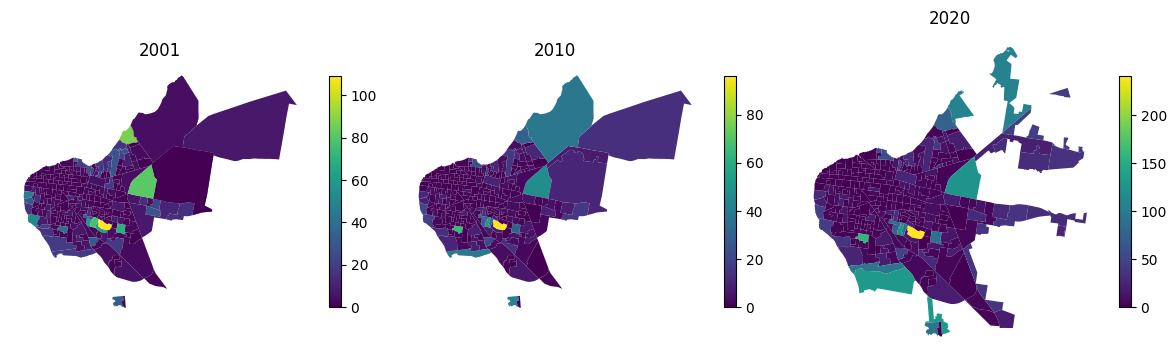

In [10]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "casilla_2020"],
    titles=[2001, 2010, 2020],
    urban_boundaries = None
)

In [11]:
# Con catname uso la distribucion de una variable en 2001 y de otra en 2010 en funcion del diccionario que pasamos como parametro
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname={"2001": "casilla", "2010": "rancho"},
    tot_colname="total_viviendas",
)

tracts_corrientes_2020["informal_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

In [12]:
tracts_corrientes_2020["informal_2020"].sum()

3412.0

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


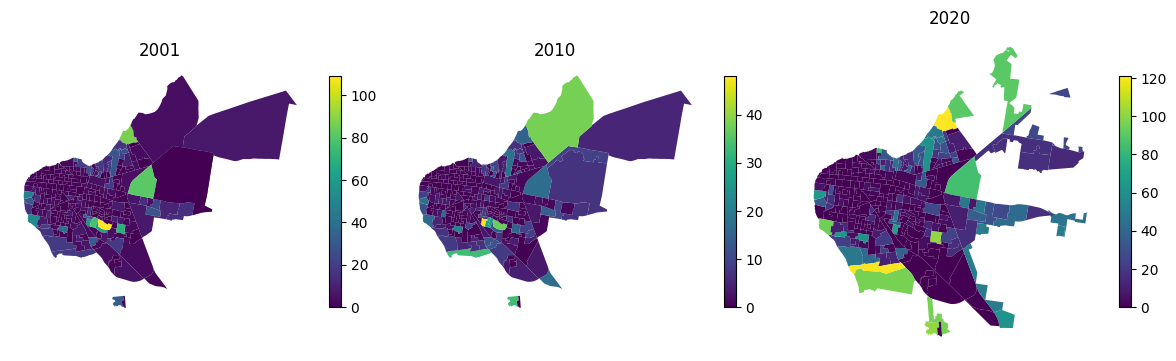

In [13]:
# evalúo las distribuciones casilla y rancho - el plot muestra cómo inciden en la distribución 2020
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "rancho", "informal_2020"],
    titles=[2001, 2010, 2020],
    urban_boundaries = None
)

In [14]:
from CENSAr.datasources import servurban_radios_prov

In [15]:
servurban_2001 = servurban_radios_prov(prov="corrientes", var_types={"link": "object"})
servurban_2001_geo = tipo_2001_geo.join(servurban_2001.set_index("link"))

In [16]:
simulated_distribution = simulate_cat_var(
    gdf_var_01=servurban_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname={"2001": "pavimento_no", "2010": "rancho"},
    tot_colname="total_viviendas",
)


tracts_corrientes_2020["informal_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


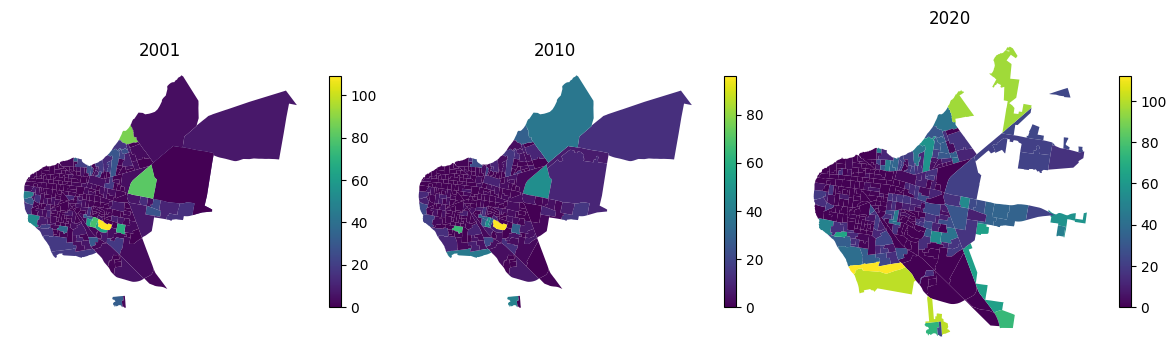

In [17]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "informal_2020"],
    titles=[2001, 2010, 2020],
    urban_boundaries = None
)

In [18]:
from copy import deepcopy
from CENSAr.aggregation import named_aggregation

formalidad_2001 = named_aggregation(tipo_2001_geo, name="tipo vivienda particular")
formalidad_2010 = named_aggregation(tipo_2010_geo, name="tipo vivienda particular")

[16:34:21] INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=494686;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=358646;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=360031;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=239644;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

           INFO     Applying named aggregation `tipo vivienda particular`                                ]8;id=120147;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=203580;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           WARNING  Extra columns found for mapping formal: {'casa a', 'casa b', 'pieza en hotel o      ]8;id=937237;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=31443;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    pension'}. Extra columns will be ignored.                                                      

           WARNING  Extra columns found for mapping situacion de calle: {'persona viviendo en la        ]8;id=676241;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=64850;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#123\123]8;;\
                    calle'}. Extra columns will be ignored.                                                        

In [19]:
formal_simulated_distribution = simulate_cat_var(
    gdf_var_01=formalidad_2001,
    gdf_var_10=formalidad_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=formalidad_2010,
    pct_val=2.5,
    catname={"2001": "formal", "2010": "formal"},
    tot_colname="total",
)
informal_simulated_distribution = simulate_cat_var(
    gdf_var_01=formalidad_2001,
    gdf_var_10=formalidad_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=formalidad_2010,
    pct_val=2.5,
    catname={"2001": "informal", "2010": "informal"},
    tot_colname="total",
)
calle_simulated_distribution = simulate_cat_var(
    gdf_var_01=formalidad_2001,
    gdf_var_10=formalidad_2010,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=formalidad_2010,
    pct_val=2.5,
    catname={"2001": "situacion de calle", "2010": "situacion de calle"},
    tot_colname="total",
)

formalidad_2020 = deepcopy(formalidad_2010)
formalidad_2020["formal"] = formalidad_2010.index.map(formal_simulated_distribution)
formalidad_2020["informal"] = formalidad_2010.index.map(informal_simulated_distribution)
formalidad_2020["situacion de calle"] = formalidad_2010.index.map(
    calle_simulated_distribution
)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


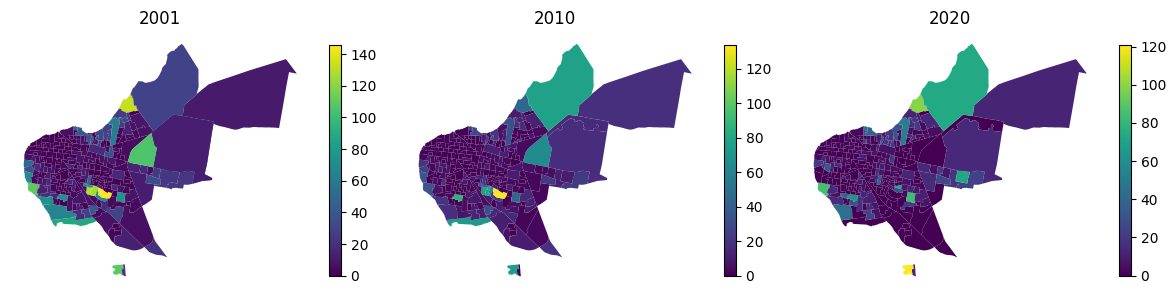

In [20]:
compare_chropleths(
    formalidad_2001,
    formalidad_2010,
    formalidad_2020,
    column="informal",
    titles=[2001, 2010, 2020],
    urban_boundaries=None
)

In [21]:
vulnerabilidad_2001 = named_aggregation(
    formalidad_2001,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2010 = named_aggregation(
    formalidad_2010,
    name="vulnerabilidad urbana",
)
vulnerabilidad_2020 = named_aggregation(
    formalidad_2020,
    name="vulnerabilidad urbana",
)

[16:34:23] INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=152146;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=289383;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=371393;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=339126;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

           INFO     Applying named aggregation `vulnerabilidad urbana`                                   ]8;id=743748;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py\core.py]8;;\:]8;id=230161;file:///home/fede/CEEU/CENSAr/CENSAr/CENSAr/aggregation/core.py#67\67]8;;\

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


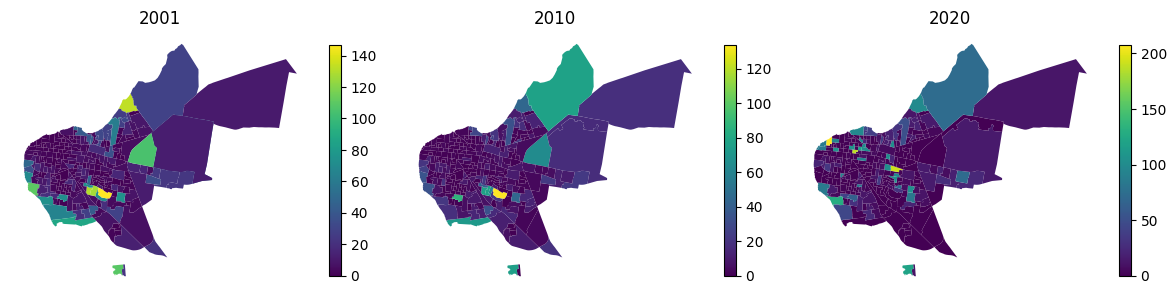

In [22]:
compare_chropleths(
    vulnerabilidad_2001,
    vulnerabilidad_2010,
    vulnerabilidad_2020,
    column="vulnerable",
    titles=[2001, 2010, 2020],
    urban_boundaries=None
)

# Correlacion espacial

Para comprender mejor los fundamentos de la autocorrelación espacial local, recurrimos al gráfico de Moran como una herramienta gráfica. En este contexto, es más intuitivo representar los datos en una forma estandarizada, ya que nos permitirá discernir más fácilmente una tipología de estructura espacial.

En un grafico de Moran podemos distinguir el tipo específico de autocorrelación espacial local en Alto-Alto (HH), Bajo-Bajo (LL), Alto-Bajo (HL) y Bajo-Alto (LH). Donde el cuadrante superior derecho muestra HH, el inferior izquierdo, LL, el superior izquierdo LH y el inferior derecho HL.

Estos tipos de autocorrelación espacial local describen similitudes o diferencias entre un polígono específico y sus polígonos vecinos. Por ejemplo, el cuadrante superior izquierdo indica que los polígonos con valores bajos están rodeados de polígonos con valores altos (LH). El cuadrante inferior derecho muestra polígonos con valores altos rodeados de vecinos con valores bajos (HL). Esto indica una asociación de valores diferentes.

## Formalidad viviendas: 

### Procesamiento de datos

Para comenzar este analisis primero es necesario transformar los poligonos de radio censal en una grilla hexagonal

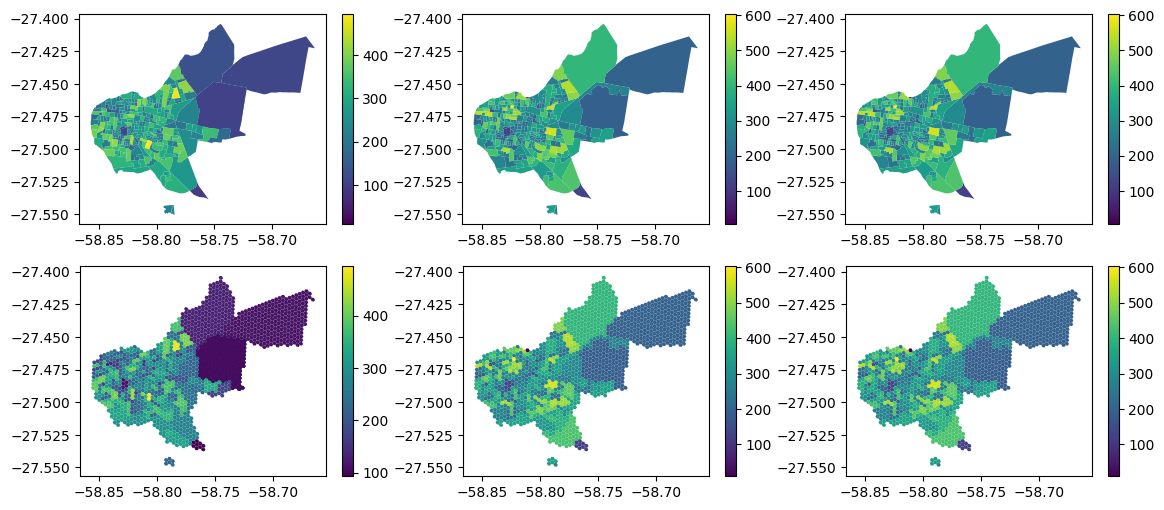

In [23]:
from CENSAr.clustering.geo_utils import geopandas_to_h3
import matplotlib.pyplot as plt

fig, subplots = plt.subplots(2, 3, figsize=(14, 6))

formalidad_2001_h3 = geopandas_to_h3(formalidad_2001, resolution=9)
formalidad_2010_h3 = geopandas_to_h3(formalidad_2010, resolution=9)
formalidad_2020_h3 = geopandas_to_h3(formalidad_2020, resolution=9)

for ax, gdf in zip(subplots[0], [formalidad_2001, formalidad_2010, formalidad_2020]):
    gdf.plot(column="total", legend=True, ax=ax)
for ax, gdf in zip(
    subplots[1], [formalidad_2001_h3, formalidad_2010_h3, formalidad_2020_h3]
):
    gdf.plot(column="total", legend=True, ax=ax)

### Formalidad de viviendas 2001

In [24]:
from CENSAr.clustering.moran import lisa
from CENSAr.plots import plot_local_autocorrelation

In [25]:
import pandas as pd

P_VALUE = 0.05

indicadores = ["formal", "informal", "situacion de calle"]
lisas_2001 = lisa(formalidad_2001, indicadores)
lisas_2001 = dict(zip(indicadores, lisas_2001))

full = pd.DataFrame(
    {
        "formal": lisas_2001["formal"].Is,
        "informal": lisas_2001["informal"].Is,
        "situacion de calle": lisas_2001["situacion de calle"].Is,
    }
)
mean = (full > P_VALUE).mean(axis=0)
mean

formal                0.506623
informal              0.655629
situacion de calle    0.006623
dtype: float64

In [26]:
global_formal, global_informal, global_calle =  lisa(formalidad_2001, indicadores, local=False)
[print(f"Autocorrelación espacial global:{round(i,2)}") for i in (global_formal.I, global_informal.I, global_calle.I)];

Autocorrelación espacial global:0.23
Autocorrelación espacial global:0.24
Autocorrelación espacial global:-0.04


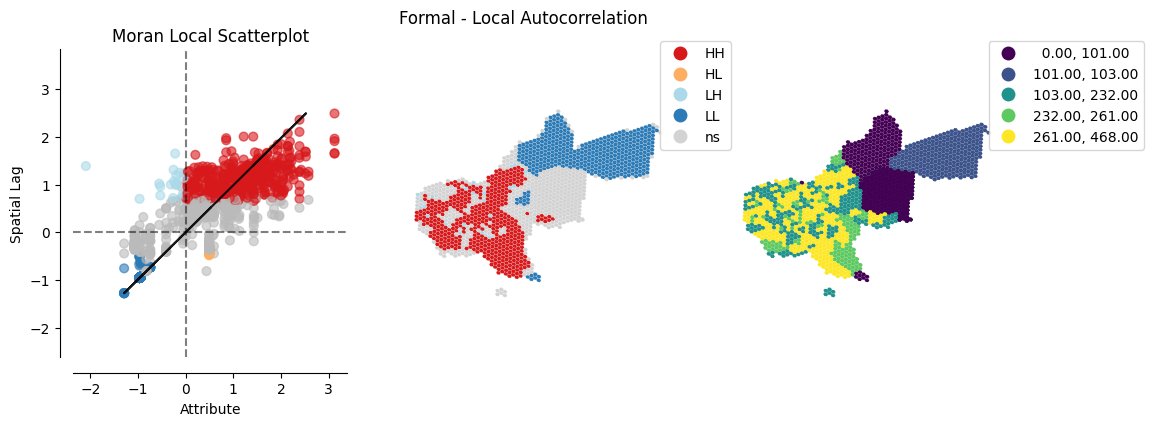

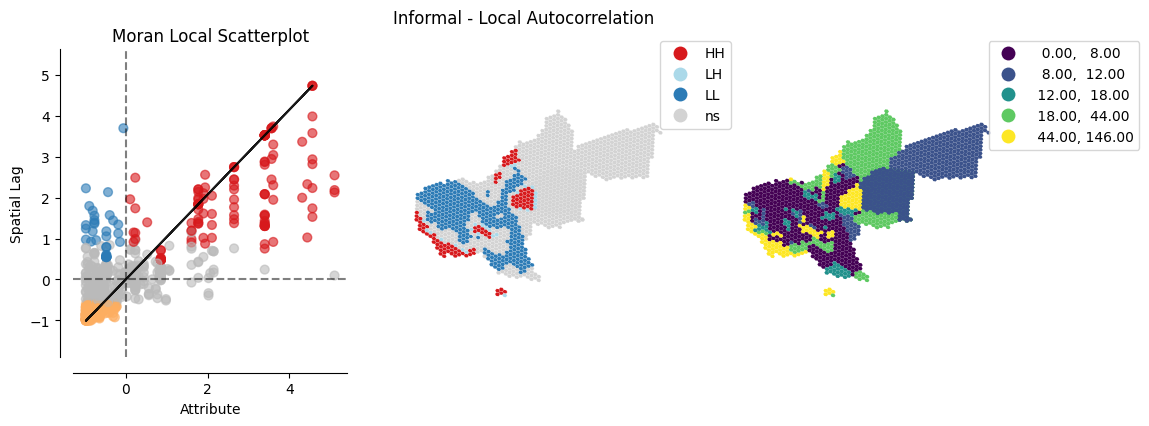

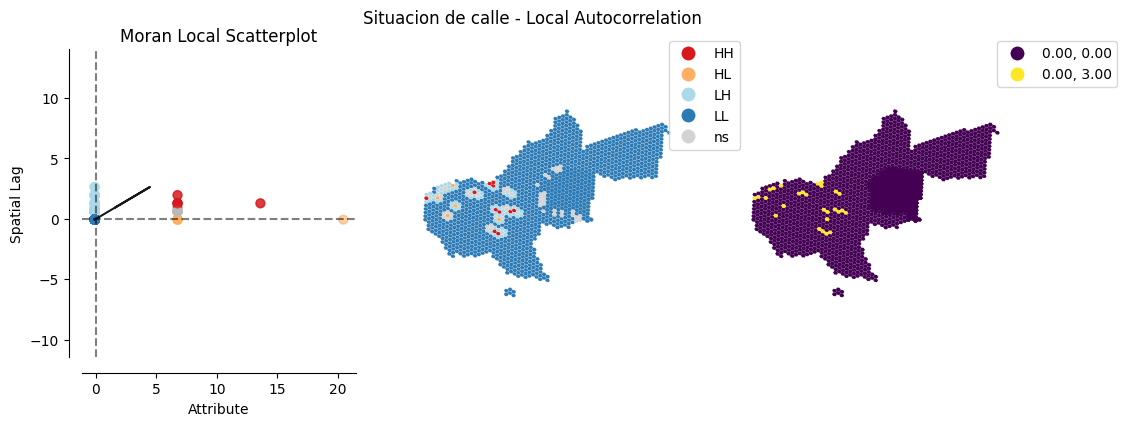

In [27]:
plot_local_autocorrelation(
    formalidad_2001_h3, ["formal", "informal", "situacion de calle"], figsize=(12, 4)
)

### Formalidad de viviendas 2010

In [28]:
import pandas as pd

P_VALUE = 0.05

indicadores = ["formal", "informal", "situacion de calle"]
lisas_2010 = lisa(formalidad_2010, indicadores)
lisas_2010 = dict(zip(indicadores, lisas_2010))

full = pd.DataFrame(
    {
        "formal": lisas_2010["formal"].Is,
        "informal": lisas_2010["informal"].Is,
        "situacion de calle": lisas_2010["situacion de calle"].Is,
    }
)
mean = (full > P_VALUE).mean(axis=0)
mean

formal                0.526984
informal              0.615873
situacion de calle    0.682540
dtype: float64

In [29]:
global_formal, global_informal, global_calle =  lisa(formalidad_2010, indicadores, local=False)
[print(f"Autocorrelación espacial global:{round(i,2)}") for i in (global_formal.I, global_informal.I, global_calle.I)];

Autocorrelación espacial global:0.18
Autocorrelación espacial global:0.2
Autocorrelación espacial global:-0.02


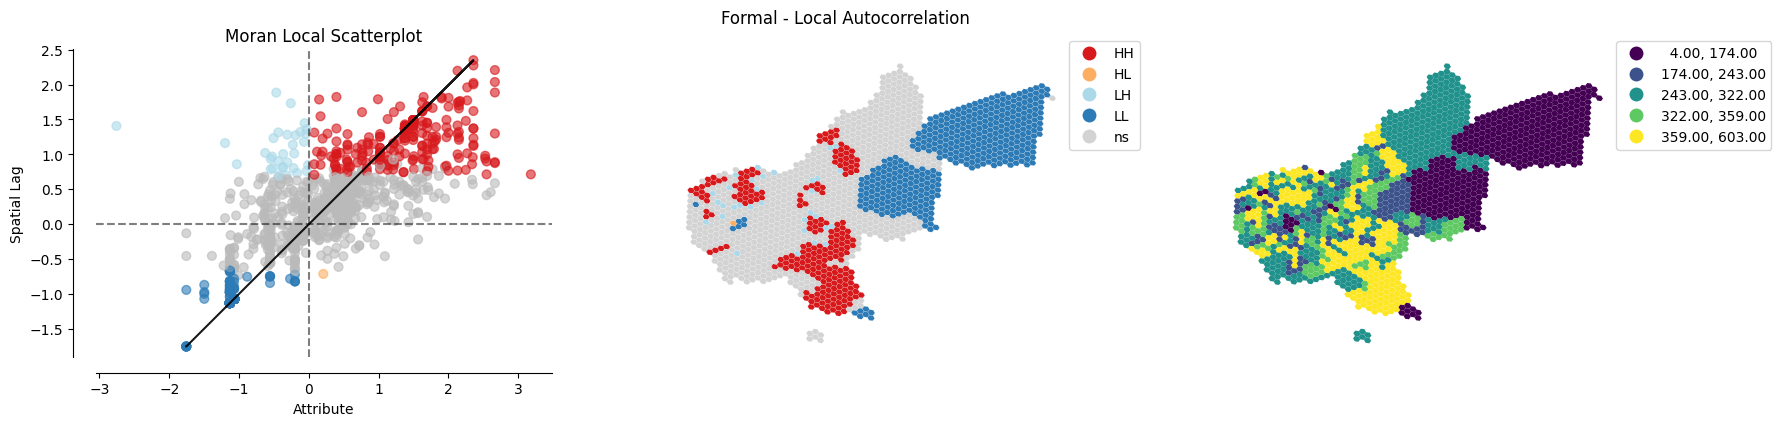

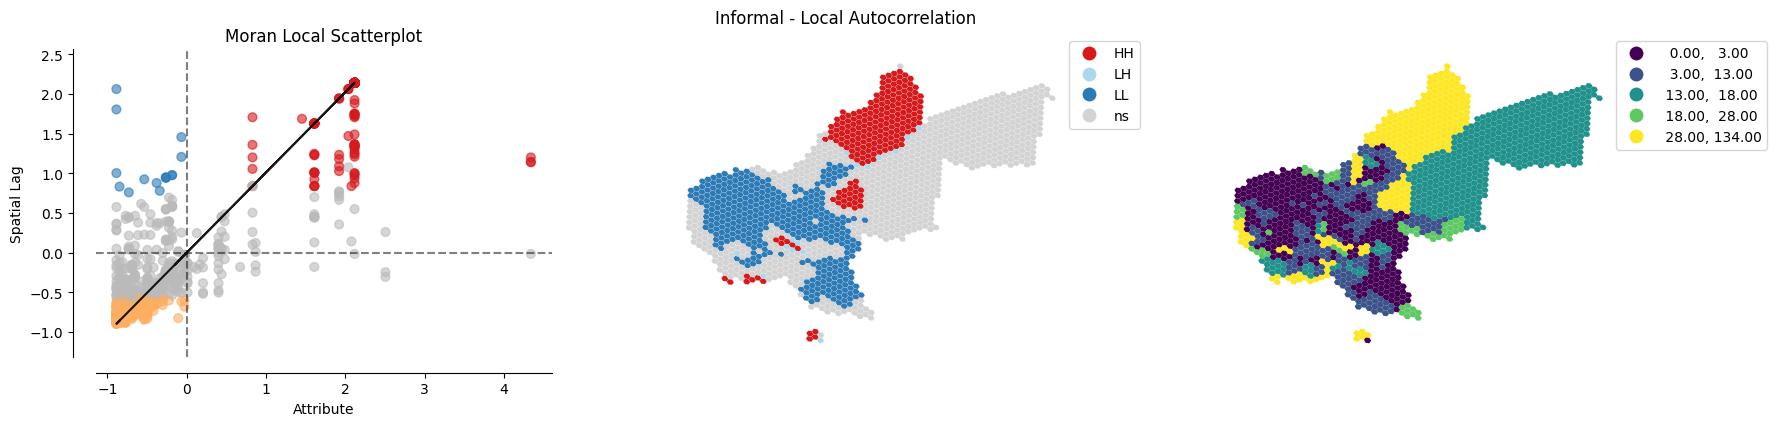

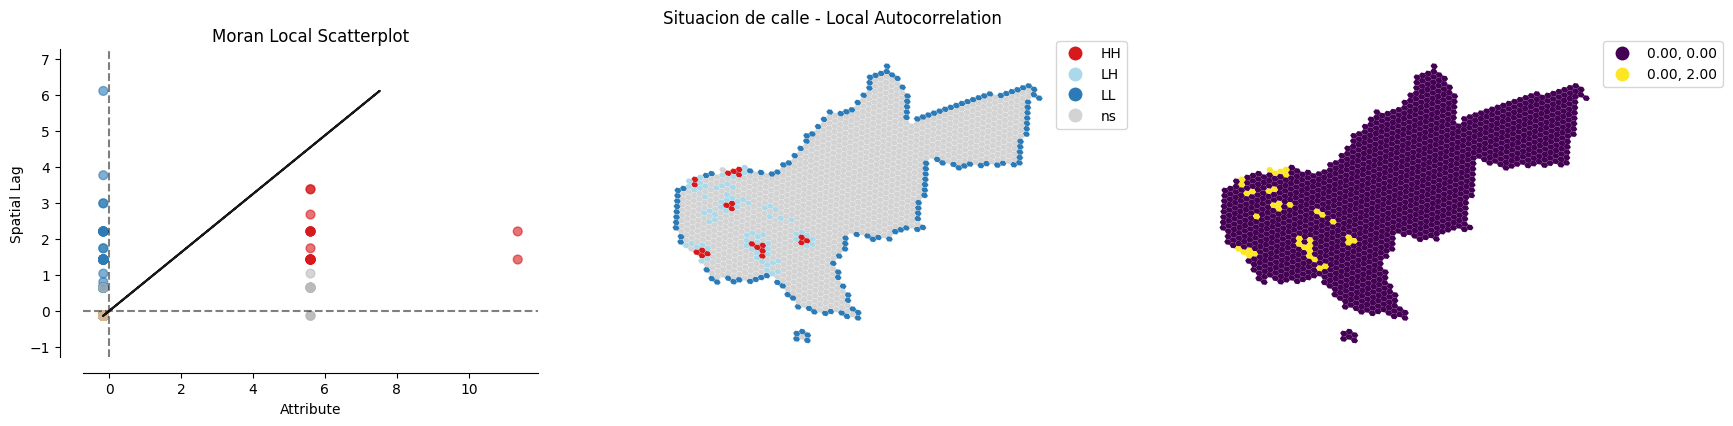

In [30]:
plot_local_autocorrelation(
    formalidad_2010_h3, ["formal", "informal", "situacion de calle"], figsize=(20, 4)
)

### Formalidad de viviendas 2020

In [31]:
import pandas as pd

P_VALUE = 0.05

indicadores = ["formal", "informal", "situacion de calle"]
lisas_2020 = lisa(formalidad_2020, indicadores)
lisas_2020 = dict(zip(indicadores, lisas_2020))

full = pd.DataFrame(
    {
        "formal": lisas_2020["formal"].Is,
        "informal": lisas_2020["informal"].Is,
        "situacion de calle": lisas_2020["situacion de calle"].Is,
    }
)
mean = (full > P_VALUE).mean(axis=0)
mean

formal                0.609524
informal              0.625397
situacion de calle    0.698413
dtype: float64

In [32]:
global_formal, global_informal, global_calle =  lisa(formalidad_2020, indicadores, local=False)
[print(f"Autocorrelación espacial global:{round(i,2)}") for i in (global_formal.I, global_informal.I, global_calle.I)];

Autocorrelación espacial global:0.39
Autocorrelación espacial global:0.2
Autocorrelación espacial global:0.11


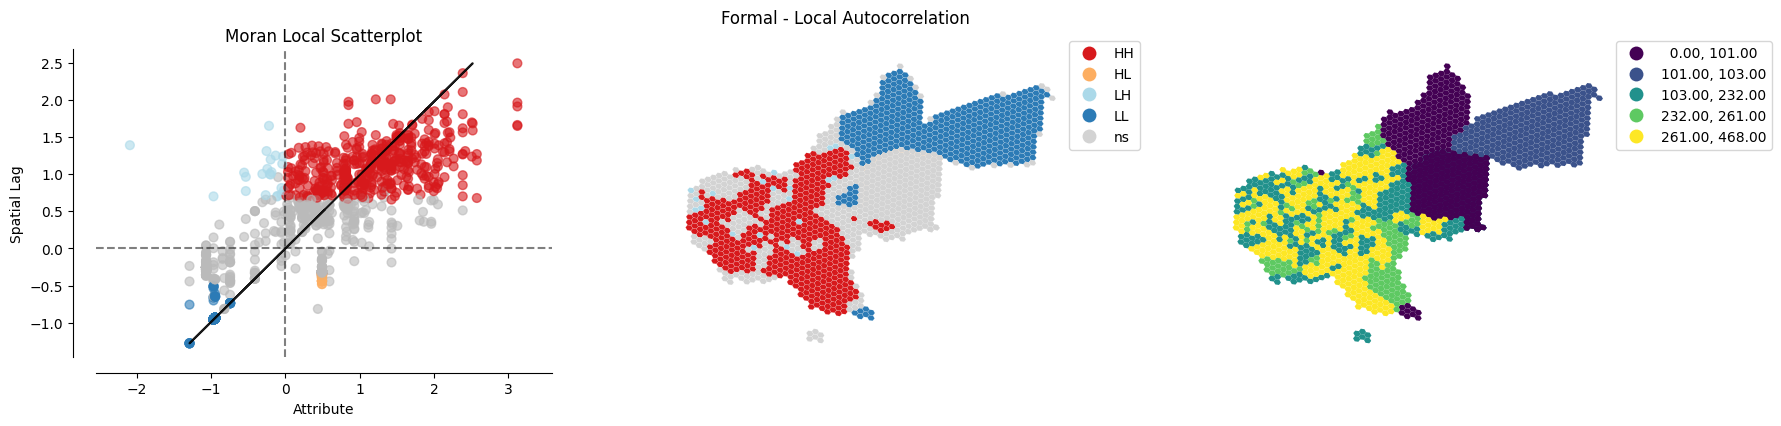

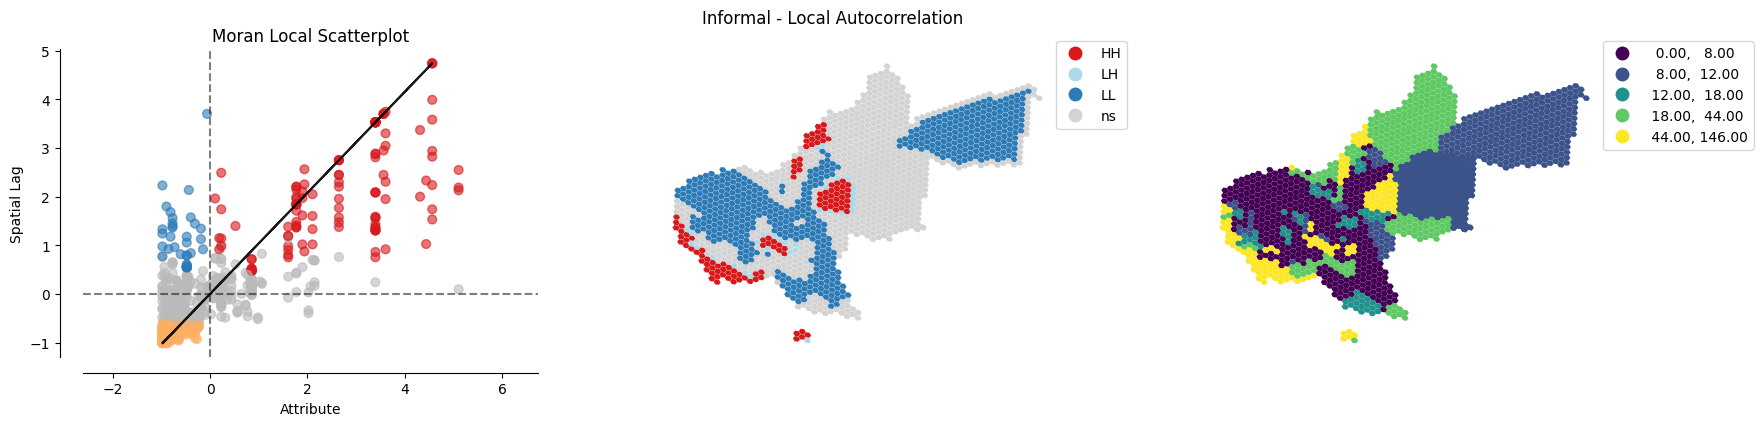

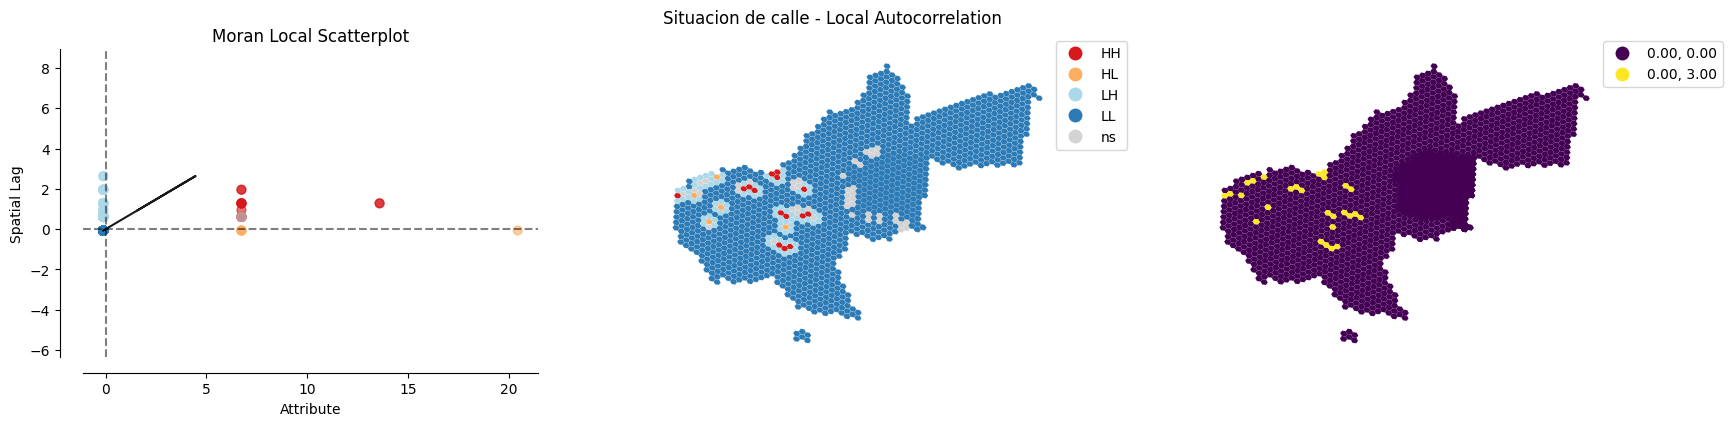

In [33]:
plot_local_autocorrelation(
    formalidad_2001_h3, ["formal", "informal", "situacion de calle"], figsize=(20, 4)
)

### Indicador por año

#### indicador: formal

Text(0.5, 0.98, '2020 - Formal')

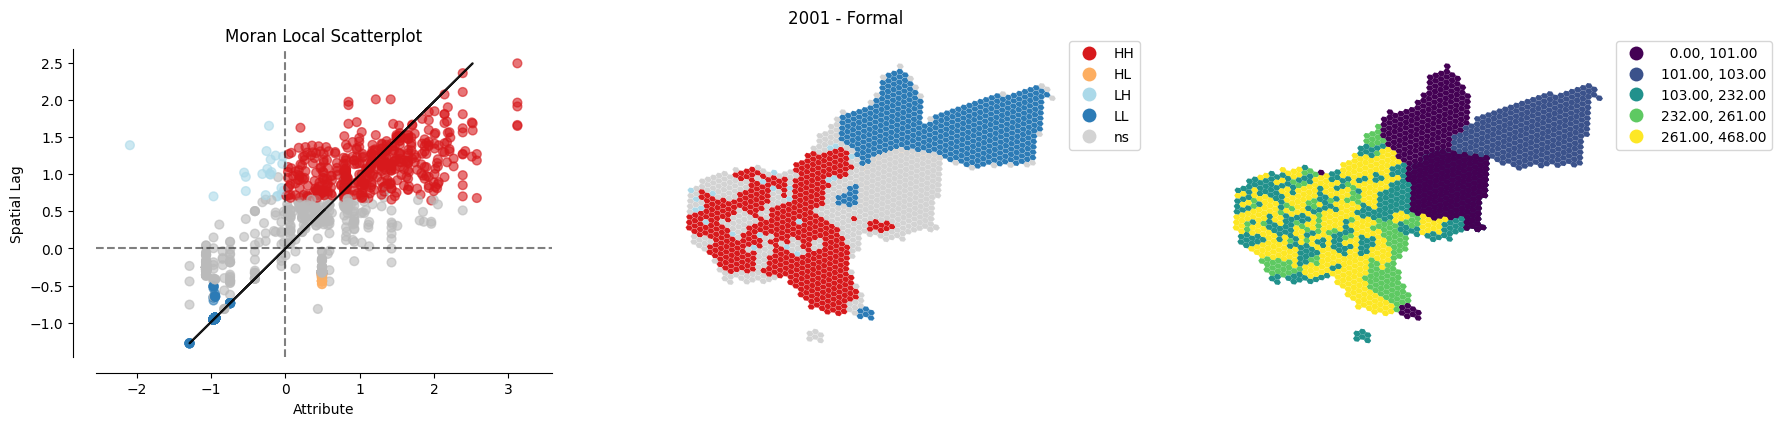

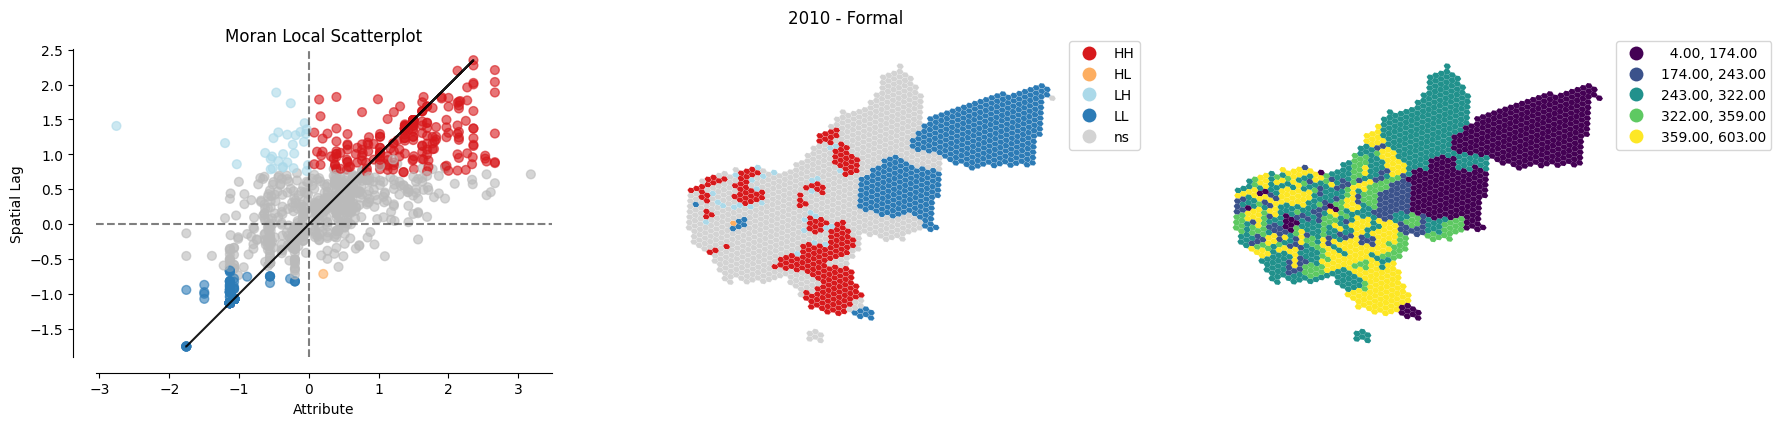

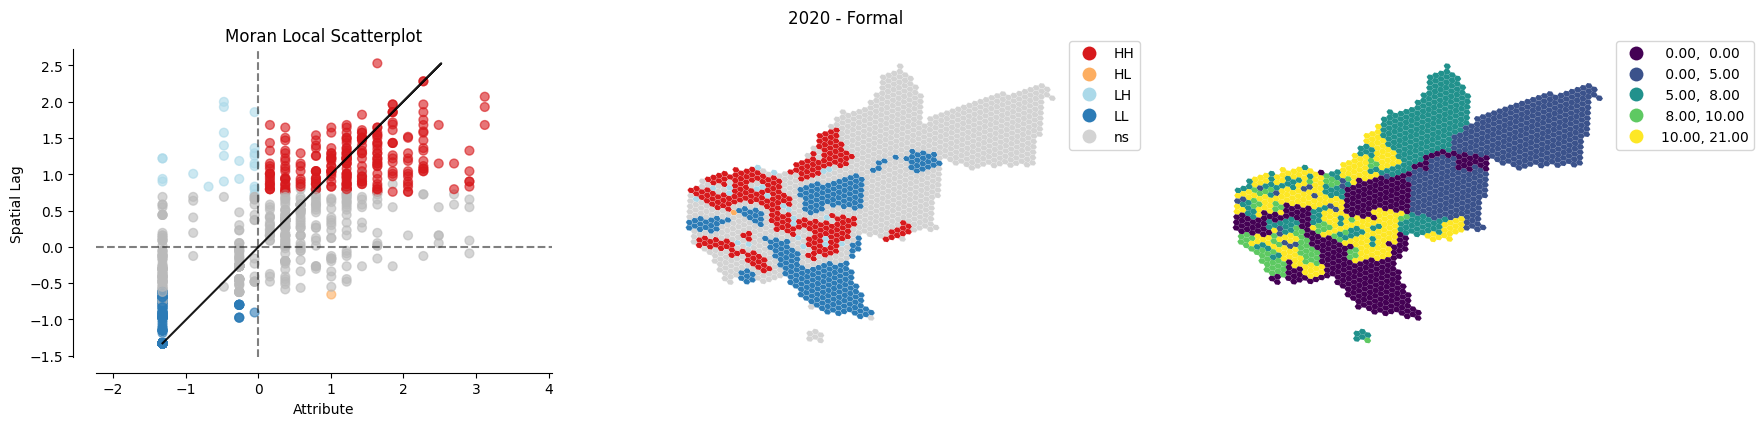

In [34]:
import matplotlib.pyplot as plt

indicador = "formal"
plot_local_autocorrelation(formalidad_2001_h3, [indicador], figsize=(20, 4))
plt.suptitle(f"2001 - {indicador.capitalize()}")
plot_local_autocorrelation(formalidad_2010_h3, [indicador], figsize=(20, 4))
plt.suptitle(f"2010 - {indicador.capitalize()}")
plot_local_autocorrelation(formalidad_2020_h3, [indicador], figsize=(20, 4))
plt.suptitle(f"2020 - {indicador.capitalize()}")

#### indicador: informal

Text(0.5, 0.98, '2020 - Informal')

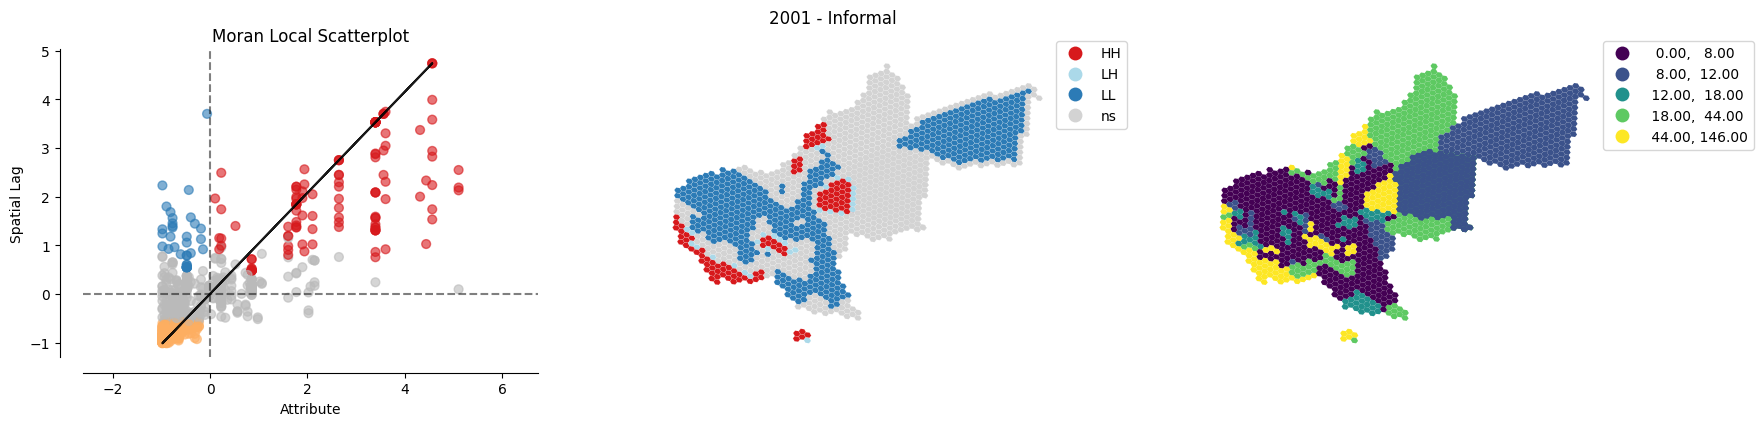

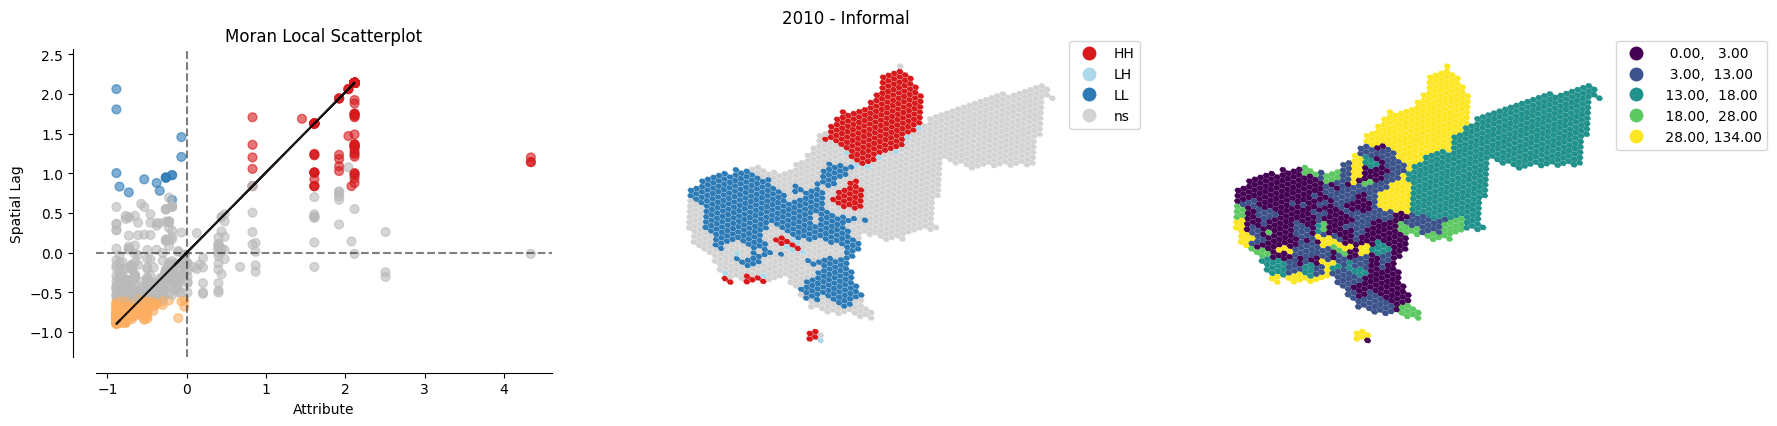

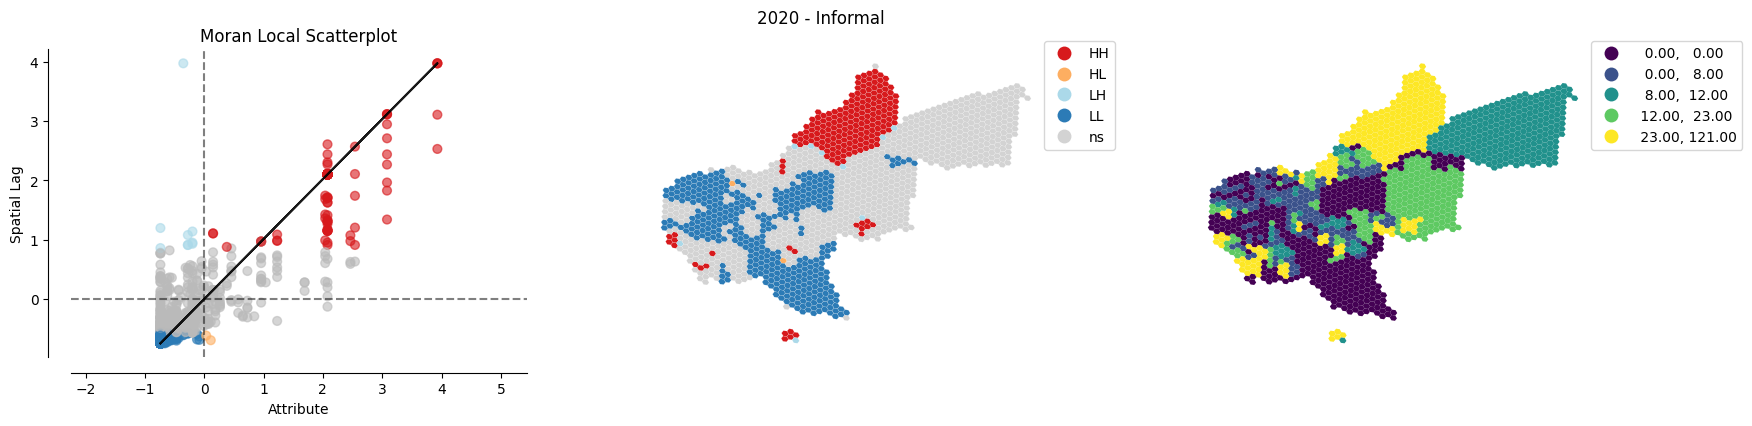

In [35]:
import matplotlib.pyplot as plt

indicador = "informal"
plot_local_autocorrelation(formalidad_2001_h3, [indicador], figsize=(20, 4))
plt.suptitle(f"2001 - {indicador.capitalize()}")
plot_local_autocorrelation(formalidad_2010_h3, [indicador], figsize=(20, 4))
plt.suptitle(f"2010 - {indicador.capitalize()}")
plot_local_autocorrelation(formalidad_2020_h3, [indicador], figsize=(20, 4))
plt.suptitle(f"2020 - {indicador.capitalize()}")

## Analisis Bivariado: Vulnerabilidad urbana 

Las estadísticas de Moran Bivariado describen la correlación entre una variable y el desplazamiento espacial de otra variable. Por lo tanto, debemos tener cuidado al interpretar nuestros resultados. Las estadísticas de Moran Bivariado no tienen en cuenta la correlación inherente entre las dos variables en la misma ubicación. Más bien, ofrecen una herramienta para medir en qué grado un polígono con un atributo específico está correlacionado con sus polígonos vecinos con un atributo diferente.

### Procesamiento de datos

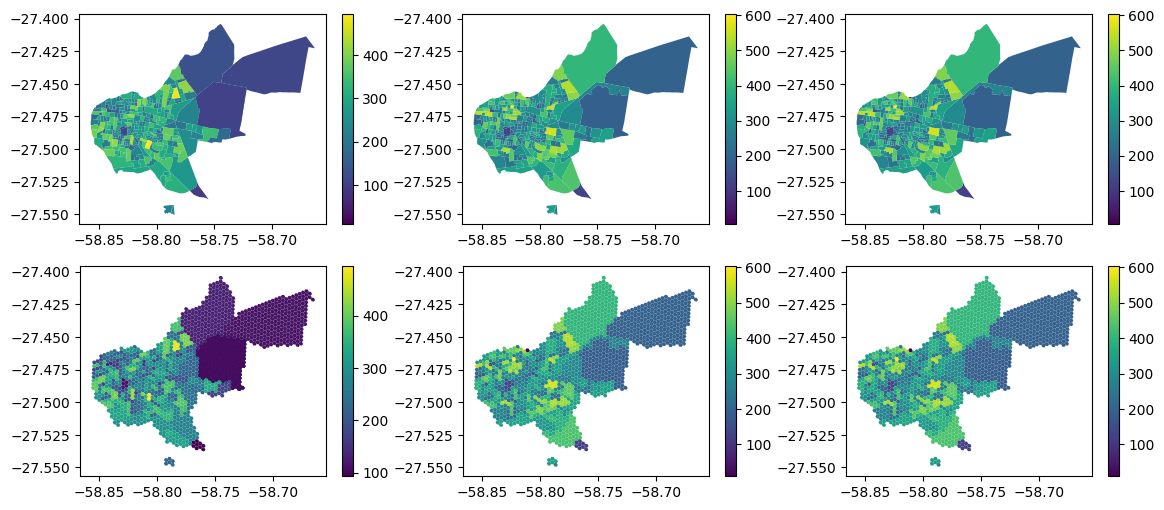

In [36]:
fig, subplots = plt.subplots(2, 3, figsize=(14, 6))

vulnerabilidad_2001_h3 = geopandas_to_h3(vulnerabilidad_2001, resolution=9)
vulnerabilidad_2010_h3 = geopandas_to_h3(vulnerabilidad_2010, resolution=9)
vulnerabilidad_2020_h3 = geopandas_to_h3(vulnerabilidad_2020, resolution=9)

for ax, gdf in zip(
    subplots[0], [vulnerabilidad_2001, vulnerabilidad_2010, vulnerabilidad_2020]
):
    gdf.plot(column="total", legend=True, ax=ax)
for ax, gdf in zip(
    subplots[1],
    [vulnerabilidad_2001_h3, vulnerabilidad_2010_h3, vulnerabilidad_2020_h3],
):
    gdf.plot(column="total", legend=True, ax=ax)

In [37]:
from CENSAr.plots import plot_local_autocorrelation_bv

### 2001

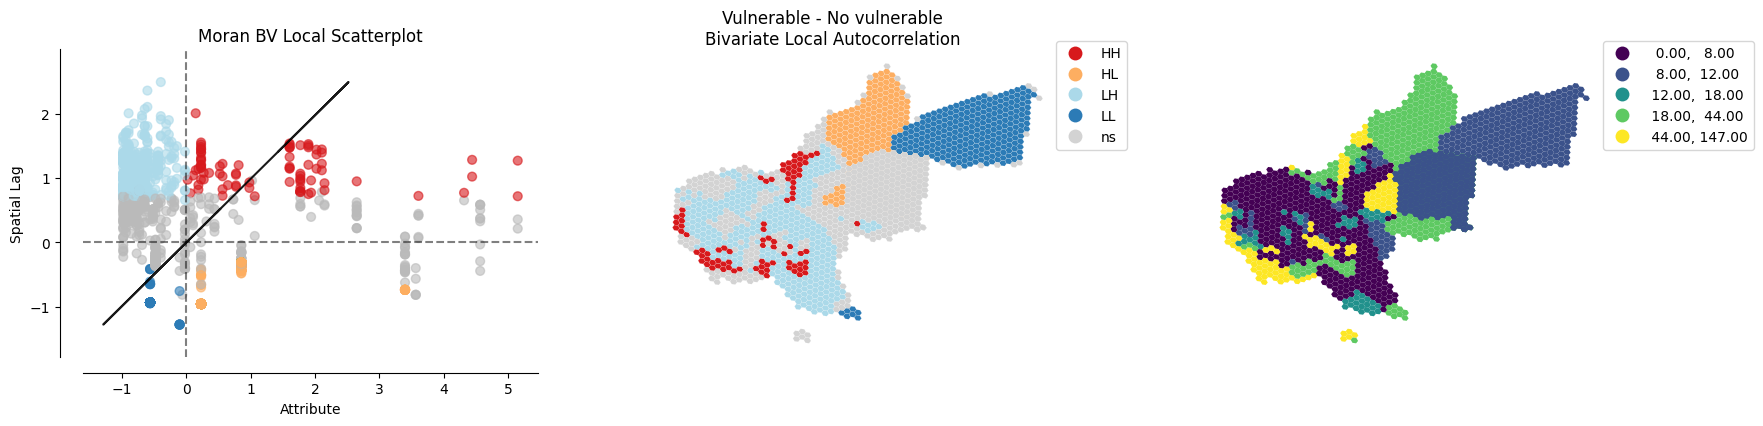

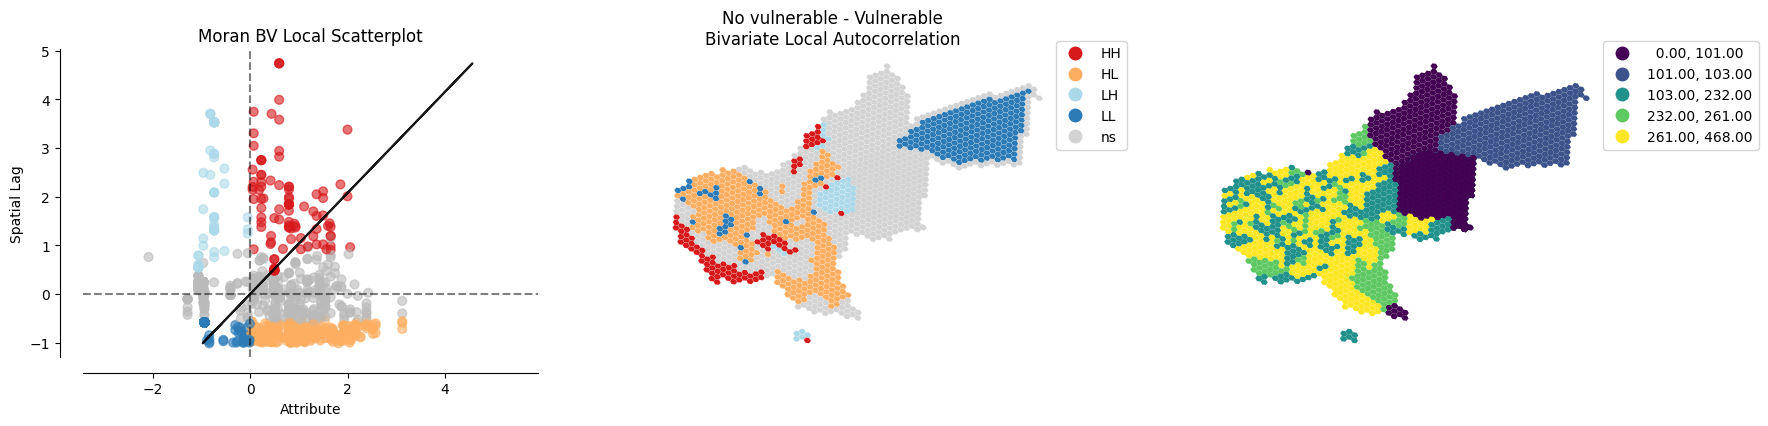

In [38]:
plot_local_autocorrelation_bv(
    vulnerabilidad_2001_h3, "vulnerable", "no vulnerable", figsize=(20, 4)
)
plot_local_autocorrelation_bv(
    vulnerabilidad_2001_h3, "no vulnerable", "vulnerable", figsize=(20, 4)
)

### 2010

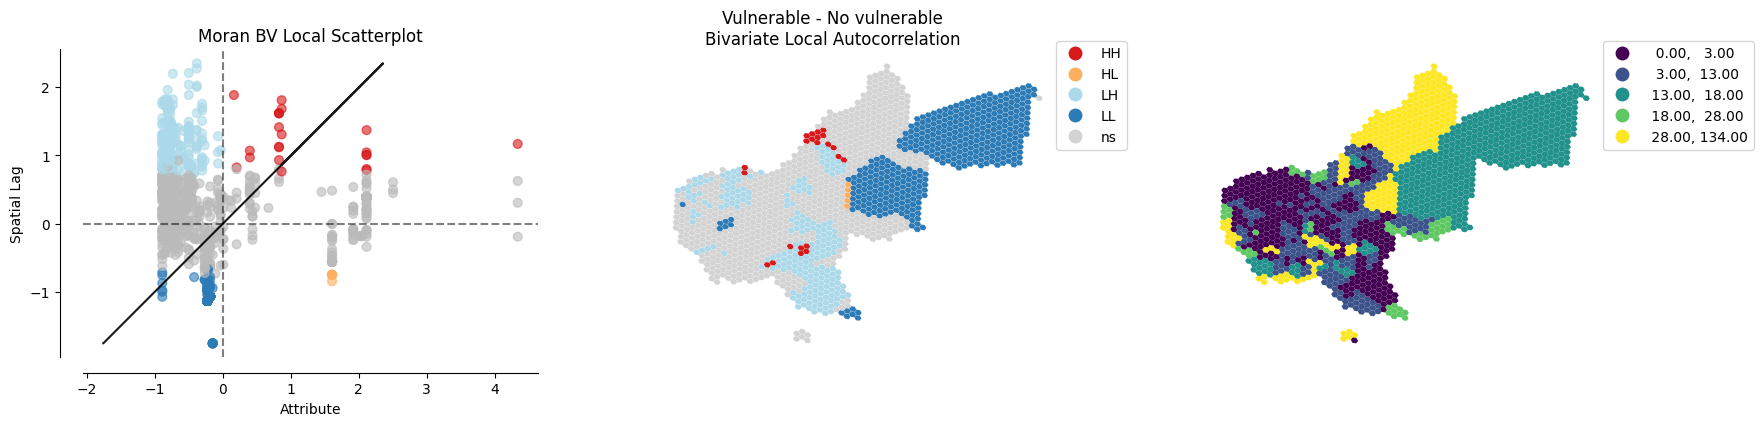

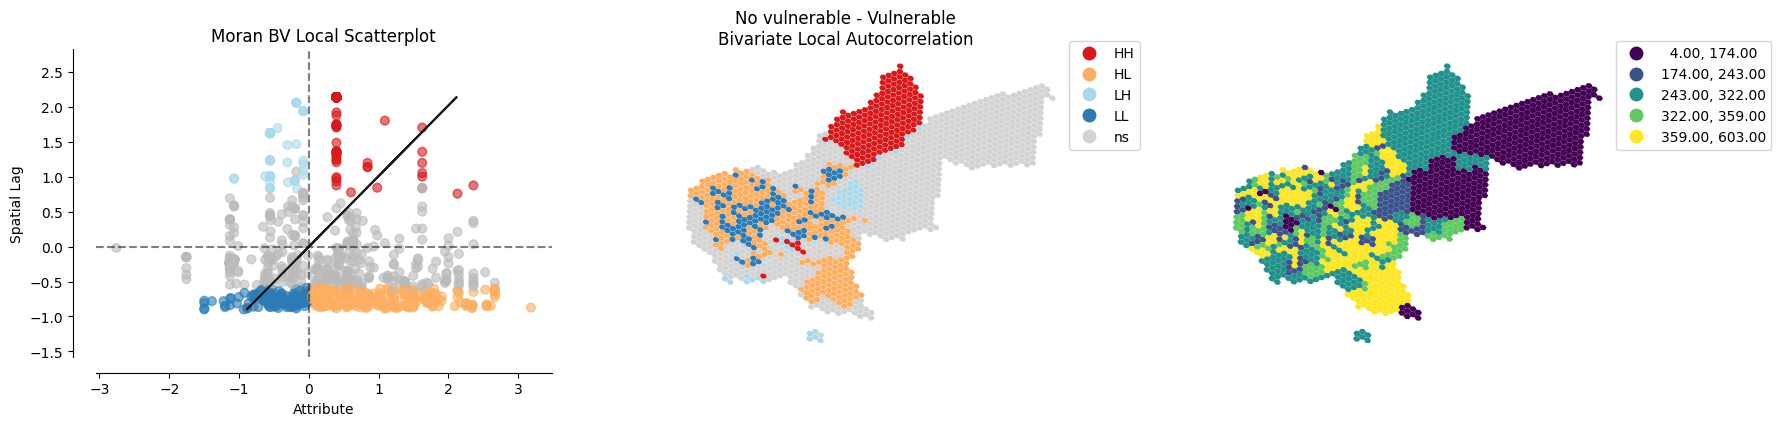

In [39]:
plot_local_autocorrelation_bv(
    vulnerabilidad_2010_h3, "vulnerable", "no vulnerable", figsize=(20, 4)
)
plot_local_autocorrelation_bv(
    vulnerabilidad_2010_h3, "no vulnerable", "vulnerable", figsize=(20, 4)
)

### 2020

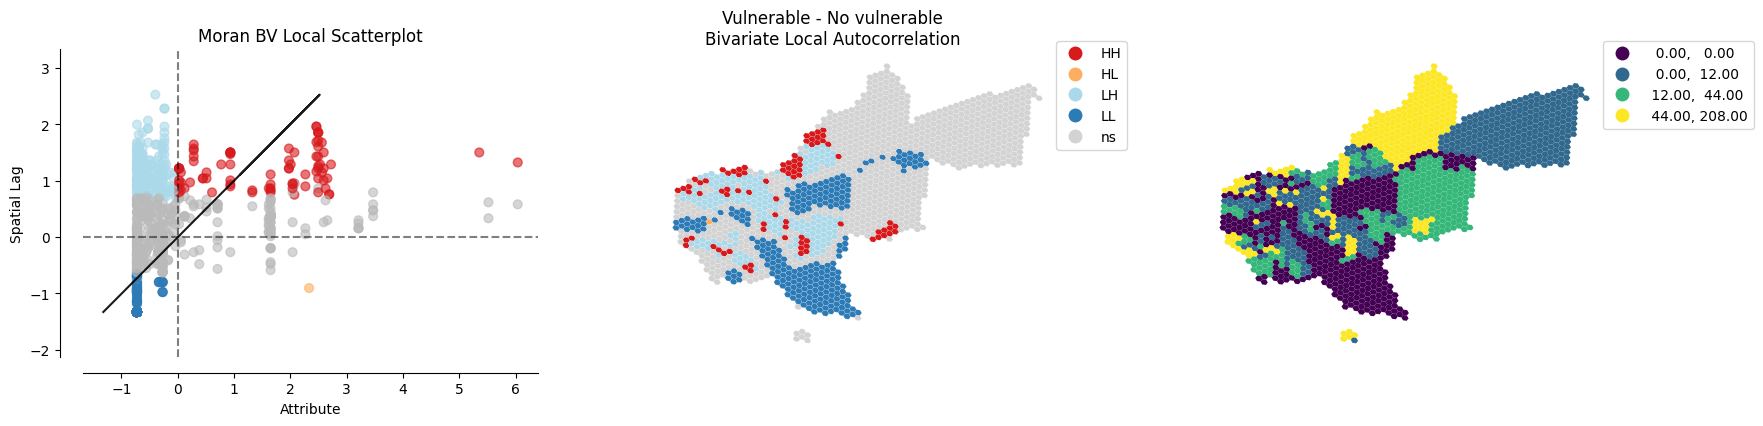

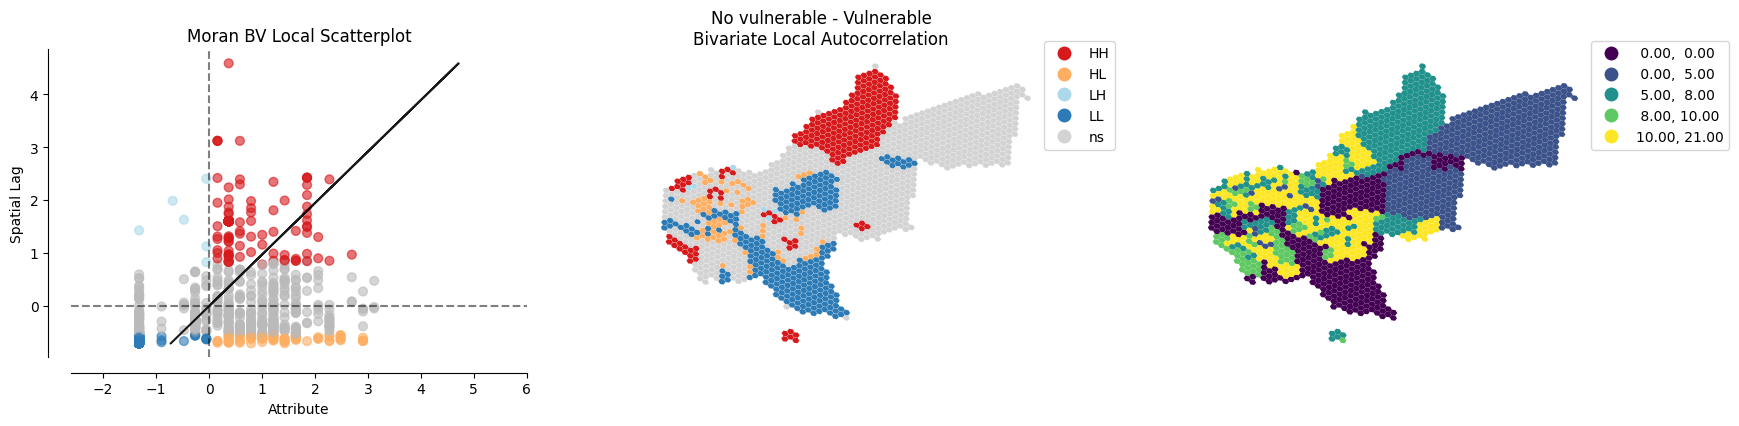

In [40]:
plot_local_autocorrelation_bv(
    vulnerabilidad_2020_h3, "vulnerable", "no vulnerable", figsize=(20, 4)
)
plot_local_autocorrelation_bv(
    vulnerabilidad_2020_h3, "no vulnerable", "vulnerable", figsize=(20, 4)
)